In [1]:
import math
import numpy as np
import scipy as sc
import scipy.optimize
import PyPDF2 as pypdf
import json
import os
from pdf2image import convert_from_path
import cv2
from functools import reduce
import sys

Function find QRs from pyexams.scan

In [2]:
from pyexams.scan import find_qrs
from pyexams.scan import is_marked

In [3]:
dpi = 300

Transformation function by pang

In [4]:
def rot(alpha):
    '''clockwise rotation

    :param: alpha in 360 degrees
    '''
    alpha_rad = alpha*np.pi/180
    return np.array([
        [np.cos(alpha_rad), np.sin(alpha_rad)],
        [-np.sin(alpha_rad), np.cos(alpha_rad)]
    ])

In [5]:
def trans(C1, C2):
    def sq(xs):
        x0, y0, scale, angle = xs
        C1_trans = np.array([[x0,y0]]) + scale*C1@rot(angle)
        return ((C1_trans - C2)**2).sum()
    x0_guess, y0_guess = C2[0,:] - C1[0,:]
    sol = sc.optimize.minimize(sq, (x0_guess, y0_guess, 1, 0), tol=1e-9, method='Powell')
    if not sol['success']:
        raise RuntimeError('Numerical error: could not find transformation matrix')
    return tuple(sol['x'])

# Transformation functions

- compare default coordinates with scan coordinates
- get rotation and scale by comparing the vectors
- get displacement by comparing the scan coordinates with the transformed (rotation and scale) default coordinates

In [6]:
def get_rotation(vector, vector_trans):
    prod = vector[0] * vector_trans[0] + vector[1] * vector_trans[1]
    d1 = math.sqrt(math.pow(vector[0], 2) + math.pow(vector[1], 2))
    d2 = math.sqrt(math.pow(vector_trans[0], 2) + math.pow(vector_trans[1], 2))
    cos = prod / (d1 * d2)
    cross_prod = vector[0] * vector_trans[1] - vector[1] * vector_trans[0]
    sin = cross_prod / (d1 * d2)
    scale = d2 / d1
    return (sin, cos), scale

In [7]:
def get_trans(points, points_trans):
    num_points = points.__len__()
    if not num_points == points_trans.__len__():
        return ()
    tr_cords = np.zeros((num_points,2))
    alpha_final, sin_final, cos_final, scale_final, dist_final = [0] * 5
    # find rotation alpha and scale
    for i in range(num_points):
        if i == num_points - 1:
            vector = [points[0,0] - points[i,0], points[0,1] - points[i,1]]
            vector_trans = [points_trans[0,0] - points_trans[i,0], points_trans[0,1] - points_trans[i,1]]
        else:
            vector = [points[i+1,0] - points[i,0], points[i+1,1] - points[i,1]]
            vector_trans = [points_trans[i+1,0] - points_trans[i,0], points_trans[i+1,1] - points_trans[i,1]]
        (sin, cos), scale = get_rotation(vector, vector_trans)
        sin_final = sin_final + sin / num_points
        cos_final = cos_final + cos / num_points
        scale_final = scale_final + scale / num_points
    alpha_final = math.atan2(sin_final, cos_final) * 180 / np.pi
    # find translation
    for i in range(num_points):
        tr_cords[i] = scale_final * points[i] @ rot(alpha_final)
        dist = points_trans[i] - tr_cords[i]
        # print(dist)
        dist_final = dist_final + dist / num_points
    return dist_final, alpha_final, scale_final
    # tr_cords + dist_final

Statement files, for default coordinates

In [8]:
st_file1 = 'question/question_11111.pdf'
st_file2 = 'question/question_22222.pdf'
st_file3 = 'question/question_33333.pdf'
st_file4 = 'question/question_44444.pdf'

Solution files, for scanned coordinates

In [9]:
ex_file1 = 'scanned/scanned_11111.pdf'
ex_file2 = 'scanned/scanned_22222.pdf'

# filled ones should have the same coords
ex_file3 = 'scanned/filled_33333.pdf'
ex_file4 = 'scanned/filled_44444.pdf'

# filled 3 rotated by 90º and 180º
ex_file2_rot90 = 'scanned/scanned_22222_rot90.pdf'
ex_file2_rot180 = 'scanned/scanned_22222_rot180.pdf'
ex_file3_rot90 = 'scanned/filled_33333_rot90.pdf'
ex_file3_rot180 = 'scanned/filled_33333_rot180.pdf'

# Test different angles of transformation for QR detection

- Does OpenCV QR detection work with QRs with a significant angle?
- Rotated filled_33333 and scanned_22222 by 90º and 180º with ilovepdf.com
- QR detection still works
- Check transformation with pang's function

In [10]:
qrs3 = find_qrs(ex_file3, dpi, False)
qrs3_rot90 = find_qrs(ex_file3_rot90, dpi, False)
qrs3_rot180 = find_qrs(ex_file3_rot180, dpi, False)

In [11]:
qr_cords3, qr_cords3_90, qr_cords3_180 = np.zeros((4,2)), np.zeros((4,2)), np.zeros((4,2))
# qr_cords3, qr_cords3_90, qr_cords3_180 = np.zeros((12,2)), np.zeros((12,2)), np.zeros((12,2))
for page in range(1):
    for point in range(4):
        qr_cords3[page*4+point] = (qrs3[page]['coordinates'][0][point])
        qr_cords3_90[page*4+point] = (qrs3_rot90[page]['coordinates'][0][point])
        qr_cords3_180[page*4+point] = (qrs3_rot180[page]['coordinates'][0][point])

In [12]:
print(qr_cords3)
print(qr_cords3_90)
print(qr_cords3_180)

[[1950.00012207 3174.        ]
 [2107.         3174.        ]
 [2107.         3331.        ]
 [1950.00012207 3331.        ]]
[[ 333. 1950.]
 [ 333. 2107.]
 [ 175. 2107.]
 [ 175. 1950.]]
[[530. 333.]
 [372. 333.]
 [372. 175.]
 [530. 175.]]


In [13]:
qrs2 = find_qrs(ex_file2, dpi, False)
qrs2_rot90 = find_qrs(ex_file2_rot90, dpi, False)
qrs2_rot180 = find_qrs(ex_file2_rot180, dpi, False)

In [14]:
qr_cords2, qr_cords2_90, qr_cords2_180 = np.zeros((4,2)), np.zeros((4,2)), np.zeros((4,2))
# qr_cords3, qr_cords3_90, qr_cords3_180 = np.zeros((12,2)), np.zeros((12,2)), np.zeros((12,2))
for page in range(1):
    for point in range(4):
        qr_cords2[page*4+point] = (qrs2[page]['coordinates'][0][point])
        qr_cords2_90[page*4+point] = (qrs2_rot90[page]['coordinates'][0][point])
        qr_cords2_180[page*4+point] = (qrs2_rot180[page]['coordinates'][0][point])

In [15]:
print(qr_cords2)
print(qr_cords2_90)
print(qr_cords2_180)

[[1891.         3100.11108398]
 [2042.72619629 3098.00390625]
 [2048.         3252.        ]
 [1893.         3252.        ]]
[[3100.11108398  571.        ]
 [3098.00390625  419.27383423]
 [3252.          414.        ]
 [3252.          569.        ]]
[[571.         333.8888855 ]
 [419.27383423 335.9961853 ]
 [414.         182.        ]
 [571.         182.        ]]


In [16]:
get_trans(qr_cords3, qr_cords3_90)

(array([3516.85954469,   -6.46104091]), 90.0, 1.0031851021350553)

# Tests to correct the coordinates of checkboxes to account for scanned exam displacement

- Get default coordinates for the QR points (in OpenCV)

In [17]:
dpi = 300

In [18]:
qr_codes1 = find_qrs(st_file1, dpi, False)
qr_codes1

[{'exam': 'test_qr',
  'variant': '11111',
  'page': '1',
  'coordinates': array([[[1950.0001, 3174.    ],
          [2107.    , 3174.    ],
          [2107.    , 3331.    ],
          [1950.0001, 3331.    ]]], dtype=float32)},
 {'exam': 'test_qr',
  'variant': '11111',
  'page': '2',
  'coordinates': array([[[1950.0001, 3174.    ],
          [2107.    , 3174.    ],
          [2107.    , 3331.    ],
          [1950.0001, 3331.    ]]], dtype=float32)},
 {'exam': 'test_qr',
  'variant': '11111',
  'page': '3',
  'coordinates': array([[[1950.0001, 3174.    ],
          [2107.    , 3174.    ],
          [2107.    , 3331.    ],
          [1950.0001, 3331.    ]]], dtype=float32)}]

In [19]:
default_cords_qr = np.zeros((4,2))
for page in range(1):
    for point in range(4):
        default_cords_qr[page * 4 + point] = (qr_codes1[page]['coordinates'][0][point])
default_cords_qr/dpi

array([[ 6.50000041, 10.58      ],
       [ 7.02333333, 10.58      ],
       [ 7.02333333, 11.10333333],
       [ 6.50000041, 11.10333333]])

- Get coordinates of the QRs in the scans

[{'exam': 'test_qr',
  'variant': '11111',
  'page': '1',
  'coordinates': array([[[1894.9999, 3098.0002],
          [2046.6063, 3098.0002],
          [2049.    , 3250.    ],
          [1895.    , 3250.    ]]], dtype=float32)},
 {'exam': 'test_qr',
  'variant': '11111',
  'page': '2',
  'coordinates': array([[[1928.    , 3060.    ],
          [2078.945 , 3057.2483],
          [2082.    , 3210.    ],
          [1930.    , 3206.    ]]], dtype=float32)},
 {'exam': 'test_qr',
  'variant': '11111',
  'page': '3',
  'coordinates': array([[[1893.    , 3099.    ],
          [2045.    , 3099.    ],
          [2045.0001, 3251.    ],
          [1893.    , 3251.    ]]], dtype=float32)}]

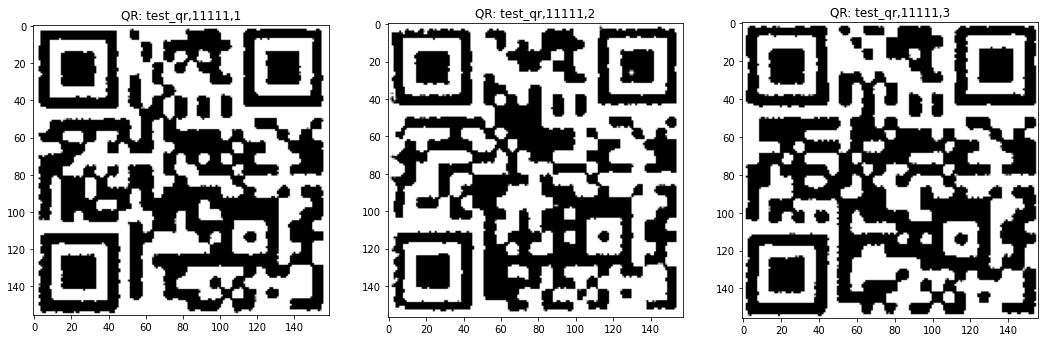

In [20]:
scan1_qrs = find_qrs(ex_file1, dpi)
scan1_qrs

In [21]:
scan1_1_cords_qr = np.zeros((4,2))
scan1_2_cords_qr = np.zeros((4,2))
scan1_3_cords_qr = np.zeros((4,2))
for page in range(1):
    for point in range(4):
        scan1_1_cords_qr[page * 4 + point] = (scan1_qrs[0]['coordinates'][0][point])
        scan1_2_cords_qr[page * 4 + point] = (scan1_qrs[1]['coordinates'][0][point])
        scan1_3_cords_qr[page * 4 + point] = (scan1_qrs[2]['coordinates'][0][point])
scan1_1_cords_qr

array([[1894.99987793, 3098.00024414],
       [2046.60632324, 3098.00024414],
       [2049.        , 3250.        ],
       [1895.        , 3250.        ]])

- OpenCV default to OpenCV scanned transformation, with pang's function

In [22]:
transform_scan1_1 = get_trans(default_cords_qr, scan1_1_cords_qr)
transform_scan1_2 = get_trans(default_cords_qr, scan1_2_cords_qr)
transform_scan1_3 = get_trans(default_cords_qr, scan1_3_cords_qr)
print(transform_scan1_1)
print(transform_scan1_2)
print(transform_scan1_3)

(array([-10.16010102,  24.44317237]), -0.22556139687286506, 0.9707405114126232)
(array([40.88153725, 28.92093948]), -0.3669457541787446, 0.9583104430084134)
(array([ 5.10009225, 26.08134046]), -1.1503476496860642e-05, 0.968153437000137)


In [23]:
dist, alpha, scale = transform_scan1_1
dist + scale * default_cords_qr @ rot(alpha)

array([[1894.89907503, 3098.09757707],
       [2047.30403581, 3097.49758779],
       [2047.90402555, 3249.90266707],
       [1895.49906478, 3250.50265635]])

- Get default coordinates of checkboxes in example exam (in pyPDF2 and OpenCV)

In [24]:
st_json_file1 = 'json/question_11111.json'
with open(st_json_file1) as json_file:
    data_st1 = json.load(json_file)
data_st1

{'exam': 'test_qr',
 'variant': '11111',
 'num_boxes': 67,
 'exercises': [{'exercise': 'vf1',
   'checkboxes': [{'checkbox': '0,0',
     'cords': [105.961, 383.659, 12.716, 12.716],
     'page': 1},
    {'checkbox': '0,1',
     'cords': [105.961, 367.719, 12.716, 12.716],
     'page': 1}]},
  {'exercise': 'vf2',
   'checkboxes': [{'checkbox': '1,0',
     'cords': [105.961, 324.103, 12.716, 12.717],
     'page': 1},
    {'checkbox': '1,1',
     'cords': [105.961, 308.163, 12.716, 12.716],
     'page': 1}]},
  {'exercise': 'vf3',
   'checkboxes': [{'checkbox': '2,0',
     'cords': [105.961, 265.739, 12.716, 12.716],
     'page': 1},
    {'checkbox': '2,1',
     'cords': [105.961, 249.799, 12.716, 12.716],
     'page': 1}]},
  {'exercise': 'vf4',
   'checkboxes': [{'checkbox': '3,0',
     'cords': [105.961, 207.375, 12.716, 12.716],
     'page': 1},
    {'checkbox': '3,1',
     'cords': [105.961, 191.434, 12.716, 12.717],
     'page': 1}]},
  {'exercise': 'vf5',
   'checkboxes': [{'checkb

In [25]:
default_coords_pypdf_boxes = np.zeros((data_st1['num_boxes'],2))
count_ex = 0
count_box = 0
for i in range(data_st1['num_boxes']):
    if count_box == data_st1['exercises'][count_ex]['checkboxes'].__len__():
        count_ex = count_ex + 1
        count_box = 0
    default_coords_pypdf_boxes[i] = data_st1['exercises'][count_ex]['checkboxes'][count_box]['cords'][0:2]
    count_box = count_box + 1
default_coords_pypdf_boxes

array([[105.961, 383.659],
       [105.961, 367.719],
       [105.961, 324.103],
       [105.961, 308.163],
       [105.961, 265.739],
       [105.961, 249.799],
       [105.961, 207.375],
       [105.961, 191.434],
       [105.961, 148.459],
       [105.961, 132.518],
       [105.961,  90.094],
       [105.961,  74.154],
       [105.961, 713.121],
       [105.961, 697.181],
       [105.961, 681.241],
       [105.961, 665.301],
       [105.961, 622.323],
       [105.961, 606.383],
       [105.961, 590.443],
       [105.961, 574.502],
       [105.961, 531.303],
       [105.961, 515.363],
       [105.961, 499.423],
       [105.961, 483.483],
       [105.961, 439.646],
       [105.961, 423.706],
       [105.961, 407.765],
       [105.961, 391.825],
       [105.961, 347.989],
       [105.961, 332.048],
       [105.961, 316.108],
       [105.961, 272.271],
       [105.961, 256.331],
       [105.961, 240.391],
       [105.961, 224.451],
       [105.961, 181.252],
       [105.961, 165.311],
 

- checkbox coordinates with openCV
- it seems to take one QR point as a checkbox, filter it out by removing marked boxes

In [29]:
dpi = 400

In [30]:
def is_valid_box(x, y, w, h, qr_points, line_min_width, a_height, stats):
    inside_qr = (qr_points[0] - line_min_width < x < qr_points[1] + line_min_width and
                 qr_points[2] - line_min_width < y < qr_points[3] + line_min_width)
    if inside_qr:
        return False
    inside_header = (y < a_height * 0.1)
    if inside_header:
        return False
    wrong_size = (w > line_min_width * 1.4 or h > line_min_width * 1.4 or
                  w < line_min_width * 0.6 or h < line_min_width * 0.6)
    if wrong_size:
        return False
    is_new = True
    for box in stats:
        if box[0] < x < (box[0] + box[2]) and box[1] < y < (box[1] + box[3]):
            is_new = False
        elif x < box[0] < (x + w) and y < box[1] < (y + h):
            is_new = False
    return is_new

In [31]:
def analyse_page(file, dpi, page, qr_coordinates):
    img = cv2.imread(file)
    line_min_width = int(dpi * 0.14)
    a_height, a_width = dpi * 11.6, dpi * 8.3
    data = {'page': page, 'boxes': []}
    qr_points = [qr_coordinates[0][0][0], qr_coordinates[0][1][0], qr_coordinates[0][0][1], qr_coordinates[0][2][1]]
    # grayscale, blur and sharpen
    gray_scale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray_scale, (5, 5), 0)
    sharpen = cv2.filter2D(blur, -1, np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]))
    _, img_bin = cv2.threshold(sharpen, 0, 225, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    img_bin = ~img_bin
    # filter the image to keep only horizontal and vertical lines of at least line_min_width
    kernel_h = np.ones((1, line_min_width), np.uint8)
    kernel_v = np.ones((line_min_width, 1), np.uint8)
    img_bin_h = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernel_h)
    img_bin_v = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernel_v)
    img_bin_final = img_bin_h | img_bin_v
    # find contours in the filtered image
    contours, hierarchy = cv2.findContours(~img_bin_final, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[::-1]  # [::-1] because the order is reversed
    stats = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if is_valid_box(x, y, w, h, qr_points, line_min_width, a_height, stats):
            stats.append([x, y, w, h])
    # check if the boxes are marked and store the data
    for x, y, w, h in stats:
        # get the inside of the box from the inverted grayscale image and check if it is marked
        x2, y2 = x + w, y + h
        box = {'stats': [x, y, w, h], 'page': page}
        inner_box = img_bin[y:y2, x:x2]
        box['is_marked'] = is_marked(inner_box, w, h)
        data['boxes'].append(box)
    return data

In [32]:
def analyse_scanned(file, dpi, qr_codes):
    img_file = 'img_temp.png'
    data = {'exam': qr_codes[0]['exam'], 'variant': qr_codes[0]['variant'], 'num_boxes': 0, 'boxes': []}
    pages_data = []
    pages = convert_from_path(file, dpi)
    for i, page in enumerate(pages):
        page.save(img_file)
        pages_data.append(
            analyse_page(img_file, dpi, qr_codes[i]['page'], qr_codes[i]['coordinates'])
        )
    pages_data.sort(key=lambda k: k['page'])
    count = 0
    for page in pages_data:
        count = count + page['boxes'].__len__()
        for box in page['boxes']:
            data['boxes'].append(box)
    data['num_boxes'] = count
    return data

In [33]:
opencv_boxes = analyse_scanned('scanned/question_11111.pdf', dpi, qr_codes1)
coords_opencv_boxes = np.zeros((data_st1['num_boxes'],2))
count = 0
for box in (opencv_boxes['boxes']):
    if not box['is_marked']:
        coords_opencv_boxes[count] = box['stats'][0:2]
        count = count + 1
coords_opencv_boxes

array([[ 524., 2481.],
       [ 524., 2569.],
       [ 524., 2811.],
       [ 524., 2900.],
       [ 524., 3136.],
       [ 524., 3224.],
       [ 524., 3460.],
       [ 524., 3549.],
       [ 524., 3787.],
       [ 524., 3876.],
       [ 524., 4112.],
       [ 524., 4200.],
       [ 524.,  650.],
       [ 524.,  739.],
       [ 524.,  827.],
       [ 524.,  916.],
       [ 524., 1155.],
       [ 524., 1243.],
       [ 524., 1332.],
       [ 524., 1420.],
       [ 524., 1660.],
       [ 524., 1749.],
       [ 524., 1837.],
       [ 524., 1926.],
       [ 524., 2170.],
       [ 524., 2258.],
       [ 524., 2347.],
       [ 524., 2435.],
       [ 524., 2679.],
       [ 524., 2767.],
       [ 524., 2856.],
       [ 524., 3099.],
       [ 524., 3188.],
       [ 524., 3277.],
       [ 524., 3365.],
       [ 524., 3605.],
       [ 524., 3694.],
       [ 524., 3782.],
       [ 524., 3871.],
       [ 524.,  650.],
       [ 524.,  739.],
       [ 524.,  827.],
       [ 524.,  916.],
       [ 52

- pyPDF2 default to OpenCV default transformation, with pang's?

In [ ]:
transformations = []

In [ ]:
dist, alpha, scale = get_trans(default_coords_pypdf_boxes, coords_opencv_boxes)
print(dist, alpha, scale)
transformations.append((dpi, dist, alpha, scale))
dist + scale * default_coords_pypdf_boxes @ rot(alpha)

In [ ]:
get_trans(np.array([[6.500,10.580], [7.025,10.580], [7.025,11.105], [6.500,11.105]]), scan1_1_cords_qr)

In [ ]:
(x0, y0), aplha, scale = get_trans(np.array([[6.500,10.580], [7.025,10.580], [7.025,11.105], [6.500,11.105]]), scan1_1_cords_qr)
x0, y0, aplha, scale

In [ ]:
transformations

In [ ]:
dpi_list = [tr_i[0] for tr_i in transformations]
x0_list = [tr_i[1][0] for tr_i in transformations]
y0_list = [tr_i[1][1] for tr_i in transformations]
alpha_list = [tr_i[2] for tr_i in transformations]
scale_list = [tr_i[3] for tr_i in transformations]
for i in zip(dpi_list, x0_list, y0_list, alpha_list, scale_list):
    print(i[0], i[1]/i[0], i[2]/i[0], i[3], i[4]/i[0])

In [ ]:
coords_opencv_boxes - (dist + scale * default_coords_pypdf_boxes @ rot(alpha))

# Test checkbox detection directly with the coordinates (for each page)

- get the transformation of the coordinates from the statement to the scanned version
- look for the boxes within a range proportional to the min_width (dpi * 0.14)
- look for contours within that range?

In [ ]:
dpi = 300

In [ ]:
"""x0_ini, y0_ini, alpha_ini, scale_ini = """
dpi * 2.78148, dpi * 11.52937, 180, dpi * 0.013887

In [ ]:
default_coords_pypdf_boxes[0:12], default_coords_pypdf_boxes[12:39], default_coords_pypdf_boxes[39:67]

In [ ]:
qr_codes_scan1 = find_qrs(ex_file1, 300)

In [ ]:
qr_codes_scan1

In [ ]:
default_cords_qr

In [ ]:
def anal_sc_test(file, dpi, qr_codes, statement_data):
    img_file = 'img_temp.png'
    data = {
        'exam': qr_codes[0]['exam'],
        'variant': qr_codes[0]['variant'],
        'num_boxes': statement_data['num_boxes'],
        'exercises': []
    }
    pages_data = []
    pages = convert_from_path(file, dpi)
    pages_st_data = split_pages(statement_data)
    for i, page in enumerate(pages):
        # get the data for the page indicated in the qr, in case the pages are out of order
        if i < pages_st_data.__len__():
            st_page = pages_st_data[qr_codes[i]['page']]
        # in case the exam has more pages without checkboxes
        else:
            st_page = {'structure': [], 'coordinates': []}
        page.save(img_file)
        pages_data.append(
            anal_p_test(img_file, dpi, qr_codes[i]['page'], qr_codes[i]['coordinates'][0], st_page['structure'],
                         np.array(st_page['coordinates']))
        )
    # sorts the data by page number and appends it
    pages_data.sort(key=lambda k: k['page'])
    for page in pages_data:
        data['exercises'].extend(page['exercises'])
    return data

In [ ]:
np.array([[6.500,10.580], [7.025,10.580], [7.025,11.105], [6.500,11.105]]) * dpi

Qué pasa si no detecta ningun contorno valido donde deberia encontrar la caja?
Cómo reconocer en el código cuando esto pasa

In [ ]:
a = [(0,0), (1,1), (2,2), (3,3), ()]
for i in a:
    if i:
        a1, a2 = i
        print(a1, a2)
    else:
        print(i)

transform json data to split the structural info from the coordinates, from the coordinates, and to split all data by the page it belongs to
splitting by page is needed to check the boxes in each page
splitting structure from coords is needed to transform the coords in

In [ ]:
data_st1

In [ ]:
def split_pages(data):
    count_page = 1
    pages = {'%i' % count_page: {'structure': [], 'coordinates': []}}
    for exercise in (data['exercises']):
        for checkbox in exercise['checkboxes']:
            # in case the exam has pages without checkboxes
            while checkbox['page'] > count_page:
                count_page = count_page + 1
                pages['%i' % count_page] = ({'structure': [], 'coordinates': []})
            pages['%i' % count_page]['structure'].append({
                'exercise': exercise['exercise'],
                'checkbox': checkbox['checkbox']
            })
            pages['%i' % count_page]['coordinates'].append([
                checkbox['cords'][0], checkbox['cords'][1]
            ])
    return pages

In [ ]:
split_data_st1 = split_pages(data_st1)
split_data_st1

In [ ]:
np.array(split_data_st1[0]['coordinates'])

In [ ]:
split_data_st1[0]['structure']

In [ ]:
([[20, 20]] + [[12,12]] @ rot(180) * 0.5)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def preprocess_img(img, line_min_width, circle_min_width):
    gray_scale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    morph = cv2.morphologyEx(~gray_scale, cv2.MORPH_CLOSE, kernel)
    _, thresh = cv2.threshold(~morph, 0, 225, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    img_bin = ~thresh

    # filter the image to keep only horizontal and vertical lines of at least line_min_width
    kernel_h = np.ones((1, line_min_width), np.uint8)
    kernel_v = np.ones((line_min_width, 1), np.uint8)
    img_bin_h = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernel_h)
    img_bin_v = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernel_v)
    img_bin_squares = img_bin_h | img_bin_v

    # filter the image to keep only circles
    kernel_circle = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (circle_min_width, circle_min_width))
    img_bin_circles = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernel_circle)

    return img_bin, img_bin_squares, img_bin_circles

In [ ]:
def find_amc_circles(amc_circles_expect, circle_min_width, img_bin_circle):
    amc_circles = []
    for circle in amc_circles_expect:
        # get area where the circle should be
        x_min, y_min= int(circle[0] - circle_min_width * 3), int(circle[1] - circle_min_width * 3)
        x_max, y_max = int(circle[0] + circle_min_width * 3), int(circle[1] + circle_min_width * 3)
        outer_box = img_bin_circle[y_min:y_max, x_min:x_max]
        contours, _ = cv2.findContours(~outer_box, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contour = ()
        for c in contours:
            x, y, w, h = cv2.boundingRect(c)
            x = x_min + x
            y = y_min + y
            if (circle_min_width < w < circle_min_width * 1.4) and (circle_min_width < h < circle_min_width * 1.4):
                contour = (x, y, w, h)
        if contour:
            x, y, w, h = contour
            amc_circles.append((x + w / 2,y + h / 2))
    return amc_circles

In [ ]:
def find_checkbox(img_bin_squares, line_min_width, expected_x, expected_y):
    # get area where the box should be
    x_min, y_min= int(expected_x - line_min_width), int(expected_y - line_min_width)
    x_max, y_max = int(expected_x + line_min_width), int(expected_y + line_min_width)
    outer_box = img_bin_squares[y_min:y_max, x_min:x_max]
    # look for contours inside the area and keep the best one
    contours, hierarchy = cv2.findContours(~outer_box, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contour = ()
    area_max = 0
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        if (line_min_width < w < line_min_width * 1.4) and (line_min_width < h < line_min_width * 1.4):
            if w * h > area_max:
                contour = (x, y, w, h)
                area_max = w * h
    # return checkbox location
    if not contour:
        # box not found, guess where it could be, less accurate
        x, y = x_min, y_min# (expected_x - line_min_width * 0.4), (expected_y - line_min_width * 0.4)
        # w = h = line_min_width
        w = x_max - x_min
        h = y_max - y_min
    else:
        x, y, w, h = contour
        x = x_min + x
        y = y_min + y
    checkbox = ([x, y, w, h])
    return checkbox

In [ ]:
def anal_p_test(file, dpi, page, qr_coordinates, st_structure, st_coordinates):
    img = cv2.imread(file)
    line_min_width = int(dpi * 0.17)
    circle_min_width = int(dpi * 0.13)
    data = {'page': page, 'exercises': []}
    img_bin, img_bin_squares, img_bin_circles = preprocess_img(img, line_min_width, circle_min_width)

    # values used to calculate the transformations
    x0_ini, y0_ini, alpha_ini, scale_ini = dpi * 2.78148, dpi * 11.529371, 180, dpi * 0.013887
    qr_default = np.array([[6.500,10.580], [7.025,10.580], [7.025,11.105], [6.500,11.105]]) * dpi
    amc_circles_default = np.array([[1.05333, 0.97], [7.21, 0.97], [1.05333, 11.03], [7.21, 11.03]]) * dpi
    (x0_scan, y0_scan), alpha_scan, scale_scan = get_trans(qr_default, qr_coordinates)

    # find amc circles
    amc_circles_expect = (x0_scan, y0_scan) + scale_scan * amc_circles_default @ rot(alpha_scan)+\
                         np.array([[circle_min_width/2, circle_min_width/2]]) @ rot(alpha_scan)
    amc_circles = find_amc_circles(amc_circles_expect, circle_min_width, img_bin_circles)
    # if it finds all 4 circles, update the transformation
    if amc_circles.__len__() == 4:
        circles = np.array(amc_circles)
        (x0_scan, y0_scan), alpha_scan, scale_scan = get_trans(amc_circles_default, circles)
        """"""
        for circle in circles:
            x, y = int(circle[0]), int(circle[1])
            d = int(circle_min_width / 2)
            cv2.rectangle(img,(x - d, y - d),(x + d, y + d),(255,0,0),2)

    # transform box coordinates from pyPDF2 to OpenCV, and correct for scan error
    coords_boxes = (x0_ini, y0_ini) + scale_ini * st_coordinates @ rot(alpha_ini)
    coords_boxes = (x0_scan, y0_scan) + scale_scan * coords_boxes @ rot(alpha_scan) +\
                   np.array([[line_min_width/2, line_min_width/2]]) @ rot(alpha_scan)

    # check the expected coordinates of each box
    stats = []
    last_ex = ''
    count_ex = -1
    fig, ax = plt.subplots(int(coords_boxes.__len__()/4) + 1, 4, figsize=(20, int(coords_boxes.__len__()/4)*5))
    count = 0
    for box_data, box in zip(st_structure, coords_boxes):
        i, j, = int(count/4), count%4
        count = count + 1
        exercise, checkbox = box_data['exercise'], box_data['checkbox']
        if exercise != last_ex:
            last_ex = exercise
            count_ex = count_ex + 1
            data['exercises'].append(
                {
                    'exercise': exercise,
                    'checkboxes': [],
                    'student_marked': []
                }
            )
        x, y, w, h = find_checkbox(img_bin_squares, line_min_width, box[0], box[1])
        x1, y1, x2, y2 = int(x), int(y), int(x + w), int(y + h)
        inner_box = img_bin[y1:y2, x1:x2]
        ax[i,j].imshow(inner_box)
        marked = is_marked(inner_box, w, h)
        ax[i,j].set_title(str(marked))
        data['exercises'][count_ex]['checkboxes'].append(
            {
                'checkbox': checkbox,
                'cords': [x, y, round(w), round(h)],
                'page': page,
                'is_marked': marked
            }
        )
        if marked:
            data['exercises'][count_ex]['student_marked'].append(checkbox)
        cv2.rectangle(img,(x1, y1),(x2, y2),(0,255,0),2)

    plt.show()

    plt.figure(figsize=(20,20))
    plt.imshow(img)
    plt.show()

    return data

In [ ]:
qrs2_400 = find_qrs(ex_file2, 400)

In [ ]:
qrs2_400

In [ ]:
anal_sc_test(ex_file2, 400, qrs2_400, data_st1)

Las coordenadas en pyPDF son la [x_min, y_min,

In [ ]:
pypdf.PdfFileReader(st_file1).getFields()

In [ ]:
anal_sc_test(ex_file2_rot90, 300, qrs2_rot90, data_st1)

In [ ]:
qrs2_rot180

In [ ]:
default_cords_qr, qr_cords2_180

In [ ]:
get_trans(default_cords_qr, qr_cords2_180)

In [ ]:
anal_sc_test(ex_file2_rot180, 300, qrs2_rot180, data_st1)

In [ ]:
qrs2_rot45 = find_qrs('scanned/scanned_22222_rot45.pdf', 300)

In [ ]:
qrs2_rot45

In [ ]:
anal_sc_test('scanned/scanned_22222_rot45.pdf', 300, qrs2_rot45, data_st1)

In [ ]:
qrs1 = find_qrs(ex_file1, dpi)
qrs1_rot90 = find_qrs(ex_file1, dpi)
qrs1_rot180 = find_qrs(ex_file1, dpi)

In [ ]:
anal_sc_test(ex_file1, 300, qrs1, data_st1)

In [ ]:
for filename in os.scandir('scanned'):
    if filename.is_file():
        file = filename.path
        print(file, os.path.splitext(file))